<b><font size=5><p align='center'>Perfil Consumidor - CETAX Consultoria</p></font></b><br><br>

<b><font size=4>Importando as bibliotecas</font></b><br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from fbprophet import Prophet
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import googlemaps
import time
import pickle

<b><font size=4>Função distance</font></b><br>
<p align="justify">Função para acessar o API do Google MAPS e retirar a distância em metros entre dois endereços distintos.</p>

In [3]:
gmaps = googlemaps.Client(key='DIGITE A SUA KEY')
def distance(origem, destino):  
    distance_result = gmaps.distance_matrix(origins=origem,
                                        destinations=destino,
                                        mode='walking', units='metric')
    if (distance_result['rows'][0]['elements'][0]['status'] == 'NOT_FOUND'):
        return 0
    else:
        return distance_result['rows'][0]['elements'][0]['distance']['value']

<b><font size=4>Pre-Processing the Dataset</font></b><br>
<p align="justify">Tratamento inicial do dataset, onde será retirado dados de clientes duplicados, calcular a idade dos clientes a partir da data de nascimento, retirar variáveis que possuem mais de 50% dos dados incompletos(NaN), variáveis de data e também variáveis que possuem o mesmo valor para mais de 75% dos dados.</p>

In [5]:
# Importando o dataset
dataset = pd.read_excel('regs.xlsx')

# Retirando dados duplicados
dataset.drop_duplicates(subset='SKASSOCIADO', inplace=True)
dataset.drop_duplicates(inplace=True)

# Tratando idade a partir da data de nascimento
idade = pd.DataFrame()
idade['Data'] = dataset.DTNASCTL
idade['Ano'] = idade.Data.replace('.*/.*/(.*)', value=r'\1', regex=True).astype(int)
idade['Idade'] = 117 - idade.Ano

# Retirando variáveis com mais de 50% dos dados incompletos
for var in dataset:
    if(dataset[var].isnull().sum() + len(dataset[var].loc[dataset[var].astype(str) == ' ']) > 3000):
        dataset.drop(var, axis=1, inplace=True)


# Retirando variaveis onde mais de 75% dos dados possuem mesmo valor
for var in dataset:
    for i in dataset[var].value_counts():
        if(i>4500):
            dataset.drop(var, axis=1, inplace=True)
    
# Retirando variáveis de data
for var in dataset:
    if (re.match('SKDT', var)):
        dataset.drop(var, axis=1, inplace=True)
    elif (re.match('DT', var)):
        dataset.drop(var, axis=1, inplace=True)
        

<b><font size=4>Feature Extraction</font></b><br>
<p align="justify">Retirando do dataset as features que serão utilizadas na clusterização.</p>

In [13]:
# Criando dataframe com as features que serão utilizadas
dtrain = pd.DataFrame()
dtrain['END_Cliente'] = dataset.NRENDERE.astype(str) + ', ' + dataset.DSENDERE + ', ' + dataset.NMBAIRRO_2+ ', ' + dataset.NMCIDADE_2
dtrain['END_Agencia'] = dataset.NRENDCOP.astype(str) + ', ' + dataset.DSENDCOP + ', ' + dataset.NMBAIRRO+ ', ' + dataset.NMCIDADE
dtrain['Seguro'] = dataset.DSSEGURO
dtrain['ValorSEG'] = dataset.VLPRESEG
dtrain['Renda'] = dataset.VL_RENDA_FATANUAL
dtrain['Idade'] = idade.Idade

# Tratamento da distância entre o endereço do cliente e da agência em que abriu o seguro

''' USO DO API DO GOOGLE MAPS PARA PEGAR A DISTANCIA ENTRE OS ENDEREÇOS,
    APÓS A PRIMEIRA EXTRAÇÃO, OS DADOS FORAM GRAVADOS EM UM ARQUIVO PICKLE PARA EVITAR REALIZAR AS MESMAS
    REQUISIÇÕES NO API NOVAMENTE
    
dtrain['Distancia'] = np.ones((5390,1))
for i in dtrain.index:
    dtrain['Distancia'][d[i]] = distance(origem=dtrain['END_Cliente'][d[i]],destino=dtrain['END_Agencia'][d[i]])

output = open('distancia.pickle', 'wb')
pickle.dump(dtrain['Distancia'], output)
output.close()

dtrain.Distancia.loc[dtrain.Distancia == 0] = np.NaN
dtrain.Distancia = dtrain.Distancia.fillna(dtrain.Distancia.mean())
'''
f = open('distancia.pickle', 'rb')
dtrain['Distancia'] = pickle.load(f)
f.close()

dtrain.drop(['END_Cliente','END_Agencia'], axis=1, inplace=True)

In [14]:
print(dtrain.head(10))

         Seguro  ValorSEG     Renda  Idade  Distancia
0          CASA     31.22   3394.49     49     5600.0
1          CASA     24.38   6409.31     74     5716.0
2          VIDA      9.56   3566.85     25     2155.0
4          VIDA     33.14   4370.26     41    56656.0
5          CASA     14.31   4000.00     54    54868.0
6          CASA     32.45  22000.00     44     6226.0
7   PRESTAMISTA      0.00   6320.00     31     5312.0
8          VIDA     21.25   5741.40     49     3865.0
9          CASA      3.91   1722.75     58    11341.0
10         CASA     24.65   1700.00     20    17920.0


<b><font size=4>Separando os dados por tipo de seguro</font></b><br>
<p align="justify">Será retirado os dados pelo tipo de seguro de cada cliente, de modo a traçar os perfis dos consumidores de seguro de casa e dos de seguro de vida (prestamistas não pagam seguro, não havendo interesse nesse caso).</p>

In [26]:
lista = list(dtrain.groupby('Seguro'))
train_casa = lista[0][1]
train_casa.drop('Seguro', axis=1, inplace=True)
train_presta = lista[1][1]
train_presta.drop('Seguro', axis=1, inplace=True)
train_vida = lista[2][1]
train_vida.drop('Seguro', axis=1, inplace=True)

<b><font size=4>Clustering via K-Means</font></b><br>
<p align="justify">Fase de clusterização, no qual os dados serão normalizados e depois será utilizado o algoritmo do K-Means para a clusterização.</p>

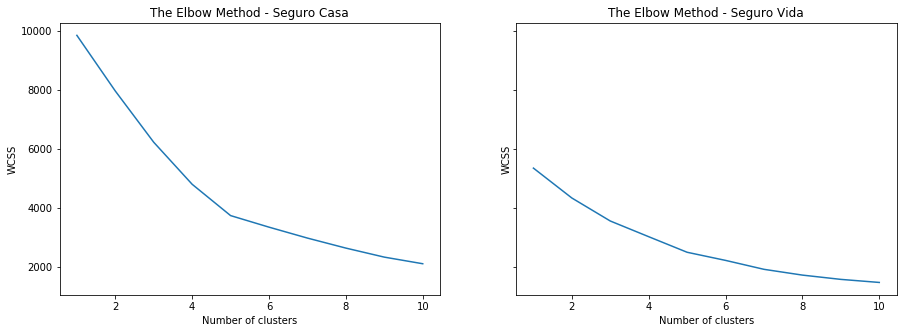

In [47]:
# Normalizando os dados
sc_casa = StandardScaler().fit(train_casa)
train_casa = sc_casa.transform(train_casa)
sc_vida = StandardScaler().fit(train_vida)
train_vida = sc_vida.transform(train_vida)

# Using the elbow method to find the optimal number of clusters
# Seguro de Casa:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True)
wcss_casa = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train_casa)
    wcss_casa.append(kmeans.inertia_)
ax1.plot(range(1, 11), wcss_casa)
ax1.set_title('The Elbow Method - Seguro Casa')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
#ax1.show()

#Seguro de Vida:
wcss_vida = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train_vida)
    wcss_vida.append(kmeans.inertia_)
ax2.plot(range(1, 11), wcss_vida)
ax2.set_title('The Elbow Method - Seguro Vida')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('WCSS')
plt.show()

<b><font size=3>Seguro de casa:</font></b><br>

In [48]:
# Fitting K-Means to the dataset
# Seguro de casa:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
resultado = kmeans.fit_predict(train_casa)
grupos = pd.DataFrame(data=resultado, columns = {'Grupo': '0'})
train_casa = sc_casa.inverse_transform(train_casa)
train_casa = pd.DataFrame(data=train_casa, columns=list(train_presta.columns))
train_casa = train_casa.join(grupos)
train_casa.Idade = train_casa.Idade.astype(int)
train_casa.ValorSEG = train_casa.ValorSEG * 12

print('Correlação das variáveis:\n',train_casa.corr().Grupo,'\n')
print('Total de pessoas por grupo:\n',train_casa.Grupo.value_counts(),'\n')
print('Valores médios por grupo:\n',train_casa.groupby('Grupo').mean(),'\n')
print('Erro de desvio por grupo:\n',train_casa.groupby('Grupo').std(),'\n')
# perfil_casa_medio = train_casa.groupby('Grupo').mean()
# total_casa = train_casa.Grupo.value_counts()
# perfil_casa_medio['TotalSEG'] = total_casa
# perfil_casa_medio['Valor_Total'] = perfil_casa_medio['TotalSEG'] * perfil_casa_medio['ValorSEG']
# perfil_casa_erro = train_casa.groupby('Grupo').std()

Correlação das variáveis:
 ValorSEG     0.557115
Renda        0.017690
Idade        0.299285
Distancia    0.021137
Grupo        1.000000
Name: Grupo, dtype: float64 

Total de pessoas por grupo:
 0    950
2    883
4    548
1     80
3      2
Name: Grupo, dtype: int64 

Valores médios por grupo:
         ValorSEG     Renda     Idade  Distancia
Grupo                                          
0      -4.329905 -0.200559 -0.416842   0.002643
1       8.409326  4.096671  0.112500  -0.058769
2      -6.086305 -0.162866  0.468856  -0.077525
3       3.519687 -0.038516  0.000000  30.684573
4      16.072685  0.012199 -0.016423   0.016928 

Erro de desvio por grupo:
         ValorSEG     Renda     Idade  Distancia
Grupo                                          
0       7.203846  0.482350  0.540197   0.492091
1      14.498746  2.257195  0.527563   0.371328
2       7.073530  0.506510  0.624421   0.241878
3      14.964065  0.606763  0.000000   0.010277
4       9.239292  0.617718  0.525149   0.717844 



<b><font size=3>Seguro de vida:</font></b><br>

In [49]:
# Fitting K-Means to the dataset
# Seguro de vida:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
resultado = kmeans.fit_predict(train_vida)
grupos = pd.DataFrame(data=resultado, columns = {'Grupo': '0'})
train_vida = sc_vida.inverse_transform(train_vida)
train_vida = pd.DataFrame(data=train_vida, columns=list(train_presta.columns))
train_vida = train_vida.join(grupos)
train_vida.Idade = train_vida.Idade.astype(int)
train_vida.ValorSEG = train_vida.ValorSEG * 12

print('Correlação das variáveis:\n',train_vida.corr().Grupo,'\n')
print('Total de pessoas por grupo:\n',train_vida.Grupo.value_counts(),'\n')
print('Valores médios por grupo:\n',train_vida.groupby('Grupo').mean(),'\n')
print('Erro de desvio por grupo:\n',train_vida.groupby('Grupo').std(),'\n')
# perfil_vida_medio = train_vida.groupby('Grupo').mean()
# total_vida = train_vida.Grupo.value_counts()
# perfil_vida_medio['TotalSEG'] = total_vida
# perfil_vida_medio['Valor_Total'] = perfil_vida_medio['TotalSEG'] * perfil_vida_medio['ValorSEG']
# perfil_vida_erro = train_vida.groupby('Grupo').std()

Correlação das variáveis:
 ValorSEG     0.209142
Renda       -0.211754
Idade       -0.543408
Distancia    0.004516
Grupo        1.000000
Name: Grupo, dtype: float64 

Total de pessoas por grupo:
 3    614
1    456
2    205
4     50
0     14
Name: Grupo, dtype: int64 

Valores médios por grupo:
         ValorSEG     Renda     Idade  Distancia
Grupo                                          
0       1.754709  6.304898  0.357143  -0.245747
1      -0.774382  0.045016  0.563596  -0.338734
2      -1.755755 -0.014488 -0.073171   1.551496
3      -2.627037 -0.213017 -0.350163  -0.268551
4      46.029664  0.499327 -0.020000   0.094738 

Erro de desvio por grupo:
         ValorSEG     Renda     Idade  Distancia
Grupo                                          
0      10.182472  4.984488  0.497245   1.901246
1       6.688417  0.652543  0.695600   0.582544
2       6.849096  0.571390  0.453215   1.240511
3       6.642202  0.413306  0.477410   0.539345
4      21.842105  1.041317  0.246610   1.049717 

